## League of Legends Churn Prediction [EDA and Wrangling] - Ben Pacheco

In the previous notebook I extracted various JSONs from Riot API endpoints. We need to clean this data and perform extensive data analysis before we feed the data into a model.

### Preface

#### What to look for when wrangling?
* missing data
* duplicate data
* tidy data (every column is a variable, every row is an observation, and every cell is a single value)

#### Basic questions to ask about the data.
* Whats the average length of a game match for all summoners?
* Are higher leveled summoners performing over all better than lower leveled summoners?
* Are veteran summoners more likely to perform?

#### Bias
The Riot API allows us to query information for all players in League of Legends. This project is limited only to a sample of Ranked League of Legends players. It is not representative of the population of all players in all game modes.

In order to predict churn in the next notebook we have to be aware of the time constraints when analyzing the data. 
* Extraction date was 05/17/2022
* Can only access data as far as 2 years ago

In this case we will say that players had their first match on the earliest dates we can extract from, so ~12/01/2020. In order to feature engineer the churn variable we have to provide a definition of churn. Churn in this case is anyone that stopped playing ranked League of Legends for more than 1 month.

### Wrangling

In [3]:
#importing packages
import os
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import math
from datetime import datetime
from IPython.display import Image

In [4]:
#set parameters for dataframes
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
FONT = {'size'   : 14}
plt.rc('font', **FONT)

In [5]:
#open json containing league ranked 5v5 information
#load json into tabular dataframe
league_dict_list = []
with open('../data/raw/league_json.json', encoding='utf-8') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        league_dict_list.append(json_data)
league_data = pd.DataFrame(league_dict_list, columns = json_data.keys())

In [6]:
league_data.head()

,summonerId,summonerName,leaguePoints,rank,wins,losses,veteran,inactive,freshBlood,hotStreak,tier,leagueId,queue
0,NNtfHnUGL5EBl6-BAbPZvPL9MXKwHH4nh28ny546ezLceL2u,Soundwave2017,0,I,3,11,False,False,False,False,IRON,a311bb83-f707-4834-a07f-54d3c9fd0178,NaN
1,LIb_E8K_EyNMOXJcVjde50-dC-zvW5H-WxmpxBtA0Ex1PcoS,kalelover666,74,I,6,10,False,False,False,True,IRON,8e8a1f5e-0135-4dee-9886-57411a0bf631,NaN
2,mMuKeCWaFDHLCBjKBTX02xql_RdrI_SWkD8lfvbuxCj5jIyB,Davidc409,100,I,33,32,False,False,False,False,IRON,605ac070-5ef0-4f60-a2a2-7648710a3e55,NaN
3,1cs3ovWaXUtFrEz9ijGUXG5EdHshSJd9SIV64xTnbclfpWFU,brownknight420,53,I,5,6,False,False,False,False,IRON,27f966d1-476d-44ea-a78e-bf0e31b319ba,NaN
4,WNu7KL4i1uHT_bZ_t6kwFi31SFsgcRiPi5JTLJt9YG2w-vFj,1st Lt LeBlanc,8,I,6,14,False,False,False,False,IRON,5069447f-305f-4b2a-ad36-9539ff7a097e,NaN


We're not interested in whether someones been inactive or not as we want to predict churn. This could significantly ruin our prediction results and therefore I'm dropping the column all together. Our analysis only includes the summoners whom participate in ranked 5v5 League of Legends so having the queue column is redundant.

In [7]:
league_data = league_data.drop(['queue', 'inactive'], axis=1)

In [8]:
sum(league_data.duplicated())

1080

In [9]:
league_data = league_data.drop_duplicates()

In [10]:
league_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52355 entries, 0 to 53434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   summonerId    52355 non-null  object
 1   summonerName  52355 non-null  object
 2   leaguePoints  52355 non-null  int64 
 3   rank          52355 non-null  object
 4   wins          52355 non-null  int64 
 5   losses        52355 non-null  int64 
 6   veteran       52355 non-null  bool  
 7   freshBlood    52355 non-null  bool  
 8   hotStreak     52355 non-null  bool  
 9   tier          52355 non-null  object
 10  leagueId      52355 non-null  object
dtypes: bool(3), int64(3), object(5)
memory usage: 3.7+ MB


We have about 52,355 summoners with their ranked league stats, we are missing quite a bit of information though. I would like to join this data with the match history data I extracted from earlier.

The match data is a nested JSON and so I must loop through it and append any key,value pair that I would like to perform analysis on.

In [11]:
match_dict_list = []
with open('../data/raw/match_json.json', encoding='utf-8') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        try:
            for participant in json_data['info']['participants']:
                participant_dict = {}
                participant_dict['match_id'] = json_data['metadata']['matchId']
                # if the key exists in dictionary then add the end time stamp
                if 'gameEndTimestamp' in json_data['info']:
                     participant_dict['game_end_timestamp'] = json_data['info']['gameEndTimestamp']
                # else set the value to null and handle it later in DF
                else:
                    participant_dict['game_end_timestamp'] = np.nan
                participant_dict['game_start_timestamp'] = json_data['info']['gameStartTimestamp']
                participant_dict['game_id'] = json_data['info']['gameId']
                participant_dict['game_version'] = json_data['info']['gameVersion']
                participant_dict['assists'] = participant['assists']
                participant_dict['kills'] = participant['kills']
                participant_dict['deaths'] = participant['deaths']
                participant_dict['lane'] = participant['lane']
                participant_dict['champion_name'] = participant['championName']
                participant_dict['gold_earned'] = participant['goldEarned']
                participant_dict['gold_spent'] = participant['goldSpent']
                participant_dict['turret_kills'] = participant['turretKills']
                participant_dict['total_dmg_dealt'] = participant['totalDamageDealt']
                participant_dict['total_heal'] = participant['totalHeal']
                participant_dict['vision_score'] = participant['visionScore']
                participant_dict['puuid'] = participant['puuid']
                participant_dict['summoner_level'] = participant['summonerLevel']
                participant_dict['summoner_name'] = participant['summonerName']
                participant_dict['time_played'] = participant['timePlayed']
                #append to list
                match_dict_list.append(participant_dict)
        except KeyError as error:
                print(json_data['info'])
                break

In [12]:
match_data = pd.DataFrame(match_dict_list, columns = participant_dict.keys())

We have the match data in tabular format, now I must get it ready to be joined with the league data.

In [13]:
match_data.head(20)

,match_id,game_end_timestamp,game_start_timestamp,game_id,game_version,assists,kills,deaths,lane,champion_name,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,puuid,summoner_level,summoner_name,time_played
0,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,5,15,16,TOP,Rengar,20760,18450,6,210892,6989,17,lYJS2jmQ7wKm9nKkuQqIQ4jJfVEHukd_fNfD7N_okrIf02...,252,pøunce,2456
1,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,11,16,14,TOP,Graves,22238,19725,1,312319,11734,25,kr1ERRnzJaWiyNw2m7ierbvC6ZpCAPnLPd4BBIC9by1Szs...,463,Flakes for Life,2456
2,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,12,10,11,MIDDLE,Azir,17203,15850,2,215061,890,26,AmwdfiakOm0n1_Qmjai7dNNHcV1P2ftIfTcYkoWt-xUOUK...,318,DragonSlayer1685,2456
3,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,15,11,4,BOTTOM,Caitlyn,17420,17325,1,187947,5644,26,IFdxqSEekvYV0Fp14AAwwLtQK4F8fMMaNbtAc1D1V19GzE...,147,Apercy021,2456
4,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,26,3,11,BOTTOM,Xerath,14529,13700,0,97753,2056,55,RApcnMnKOUUC2ZoXF0k4ORVeiSYNP_bVP7ui5w3Cb3OMdM...,179,Dudej31177,2456
5,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,5,17,8,TOP,XinZhao,20617,26850,4,208113,16192,16,672O83Bpax5PhvXzAbxPfSY1lB9fWlb8RDNUjPtVGflNhm...,549,Boku Wa Pico,2456
6,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,10,17,8,JUNGLE,Sett,19083,19290,2,257556,23473,25,JCUykG8BIsq5BTeiCOqFGGrPeDFVqgD-v5wDH9h3Xo3NMm...,304,YUNGTRENDSETTA,2456
7,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,17,9,13,JUNGLE,Ahri,15800,13875,1,171449,7452,28,FfYhmOL_WUUf5rxdh8PrpWikVly-f3lRg_9bjmYG6QiWSp...,404,Smooth Gillings,2456
8,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,14,6,8,BOTTOM,Jhin,14003,13975,0,178703,7305,26,qVOdaQQvh_u8SusqUUEPl2KvqehyNpsT-RkhUFO60Ss9fA...,212,Soundwave2017,2456
9,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,18,7,18,JUNGLE,Shaco,12970,12950,0,48573,3334,56,Zr0GbnlpX2veb7t22JEOUaS2NBh43Ld0JK4IAFKLZopqGQ...,472,SteIIioKontos,2456


In [14]:
match_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244840 entries, 0 to 244839
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   match_id              244840 non-null  object 
 1   game_end_timestamp    176940 non-null  float64
 2   game_start_timestamp  244840 non-null  int64  
 3   game_id               244840 non-null  int64  
 4   game_version          244840 non-null  object 
 5   assists               244840 non-null  int64  
 6   kills                 244840 non-null  int64  
 7   deaths                244840 non-null  int64  
 8   lane                  244840 non-null  object 
 9   champion_name         244840 non-null  object 
 10  gold_earned           244840 non-null  int64  
 11  gold_spent            244840 non-null  int64  
 12  turret_kills          244840 non-null  int64  
 13  total_dmg_dealt       244840 non-null  int64  
 14  total_heal            244840 non-null  int64  
 15  

We have much more rows of match data information because to call the Riot API endpoint one must provide a match id given from a list of puuids (see part 1 - extraction notebook). For every match id the API request will return a match played by 10 different summoners (puuids). Once we join the data with league information we will have much less rows to work with.

In [15]:
sum(match_data.duplicated())

630

In [16]:
match_data = match_data.drop_duplicates()

I need to impute values for game_end_timestamp since for any game before Oct 5th, 2021 this field did not exist. Riot API states that adding "time_played_in_match" to "game_start_timestamp" will give us the values we need.

In [17]:
missing_end_timestamps = match_data['game_start_timestamp'] + match_data['time_played']
match_data['game_end_timestamp'] = match_data['game_end_timestamp'].fillna(missing_end_timestamps)
match_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244210 entries, 0 to 244839
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   match_id              244210 non-null  object 
 1   game_end_timestamp    244210 non-null  float64
 2   game_start_timestamp  244210 non-null  int64  
 3   game_id               244210 non-null  int64  
 4   game_version          244210 non-null  object 
 5   assists               244210 non-null  int64  
 6   kills                 244210 non-null  int64  
 7   deaths                244210 non-null  int64  
 8   lane                  244210 non-null  object 
 9   champion_name         244210 non-null  object 
 10  gold_earned           244210 non-null  int64  
 11  gold_spent            244210 non-null  int64  
 12  turret_kills          244210 non-null  int64  
 13  total_dmg_dealt       244210 non-null  int64  
 14  total_heal            244210 non-null  int64  
 15  

In [18]:
#renaming columns
league_data = league_data.rename(columns={'summonerName': 'summoner_name', 'leaguePoints': 'league_points',
                                         'freshBlood': 'fresh_blood', 'hotStreak': 'hot_streak',})
league_data.head()

,summonerId,summoner_name,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,leagueId
0,NNtfHnUGL5EBl6-BAbPZvPL9MXKwHH4nh28ny546ezLceL2u,Soundwave2017,0,I,3,11,False,False,False,IRON,a311bb83-f707-4834-a07f-54d3c9fd0178
1,LIb_E8K_EyNMOXJcVjde50-dC-zvW5H-WxmpxBtA0Ex1PcoS,kalelover666,74,I,6,10,False,False,True,IRON,8e8a1f5e-0135-4dee-9886-57411a0bf631
2,mMuKeCWaFDHLCBjKBTX02xql_RdrI_SWkD8lfvbuxCj5jIyB,Davidc409,100,I,33,32,False,False,False,IRON,605ac070-5ef0-4f60-a2a2-7648710a3e55
3,1cs3ovWaXUtFrEz9ijGUXG5EdHshSJd9SIV64xTnbclfpWFU,brownknight420,53,I,5,6,False,False,False,IRON,27f966d1-476d-44ea-a78e-bf0e31b319ba
4,WNu7KL4i1uHT_bZ_t6kwFi31SFsgcRiPi5JTLJt9YG2w-vFj,1st Lt LeBlanc,8,I,6,14,False,False,False,IRON,5069447f-305f-4b2a-ad36-9539ff7a097e


Pandas allows us to perform an inner join akin to SQL using its merge method, I perform an inner join on summoner_name in order to get the master data set I need to perform analysis on.

In [19]:
master_df = pd.merge(left=league_data, right=match_data, how='inner', on='summoner_name')

In [20]:
master_df.head()

,summonerId,summoner_name,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,leagueId,match_id,game_end_timestamp,game_start_timestamp,game_id,game_version,assists,kills,deaths,lane,champion_name,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,puuid,summoner_level,time_played
0,NNtfHnUGL5EBl6-BAbPZvPL9MXKwHH4nh28ny546ezLceL2u,Soundwave2017,0,I,3,11,False,False,False,IRON,a311bb83-f707-4834-a07f-54d3c9fd0178,NA1_4306888010,1.652500e+12,1652497673802,4306888010,12.9.439.127,14,6,8,BOTTOM,Jhin,14003,13975,0,178703,7305,26,qVOdaQQvh_u8SusqUUEPl2KvqehyNpsT-RkhUFO60Ss9fA...,212,2456
1,NNtfHnUGL5EBl6-BAbPZvPL9MXKwHH4nh28ny546ezLceL2u,Soundwave2017,0,I,3,11,False,False,False,IRON,a311bb83-f707-4834-a07f-54d3c9fd0178,NA1_4304706779,1.652326e+12,1652324050698,4304706779,12.9.439.127,5,7,6,MIDDLE,Gangplank,11613,10350,1,115684,5374,17,qVOdaQQvh_u8SusqUUEPl2KvqehyNpsT-RkhUFO60Ss9fA...,211,1993
2,NNtfHnUGL5EBl6-BAbPZvPL9MXKwHH4nh28ny546ezLceL2u,Soundwave2017,0,I,3,11,False,False,False,IRON,a311bb83-f707-4834-a07f-54d3c9fd0178,NA1_4298584602,1.651806e+12,1651804414863,4298584602,12.8.437.6765,5,1,10,MIDDLE,Swain,8416,8360,0,75323,2979,15,qVOdaQQvh_u8SusqUUEPl2KvqehyNpsT-RkhUFO60Ss9fA...,210,1922
3,NNtfHnUGL5EBl6-BAbPZvPL9MXKwHH4nh28ny546ezLceL2u,Soundwave2017,0,I,3,11,False,False,False,IRON,a311bb83-f707-4834-a07f-54d3c9fd0178,NA1_4298580129,1.651804e+12,1651802904978,4298580129,12.8.437.6765,5,1,3,NONE,Swain,4849,4225,0,50486,2779,7,qVOdaQQvh_u8SusqUUEPl2KvqehyNpsT-RkhUFO60Ss9fA...,210,1167
4,NNtfHnUGL5EBl6-BAbPZvPL9MXKwHH4nh28ny546ezLceL2u,Soundwave2017,0,I,3,11,False,False,False,IRON,a311bb83-f707-4834-a07f-54d3c9fd0178,NA1_4297843161,1.651724e+12,1651721756380,4297843161,12.8.437.6765,8,6,12,MIDDLE,Swain,10215,9585,0,95855,5115,13,qVOdaQQvh_u8SusqUUEPl2KvqehyNpsT-RkhUFO60Ss9fA...,210,1835


In [21]:
sum(master_df.duplicated())

0

We don't need redundant id anymore for the analysis therefore I will drop these columns.

In [22]:
master_df = master_df.drop(['summonerId', 'leagueId', 'game_id', 'puuid'], axis=1)

Riot API provides the match start/end times in utc timestamp format, i'm going to apply a lambda function that gives me a datetime object for the timestamp columns in year-month-day hour-min-sec format.

<!-- Riot API provides the match start/end times in utc timestamp format, i'm going to apply a lambda function that gives me a datetime object for the timestamp columns in year-month-day hour-min-sec format. -->

In [23]:
master_df.game_end_timestamp = master_df.game_end_timestamp.apply(lambda x: datetime.utcfromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M:%S"))
master_df.game_start_timestamp = master_df.game_start_timestamp.apply(lambda x: datetime.utcfromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M:%S"))
master_df.game_end_timestamp = pd.to_datetime(master_df.game_end_timestamp, errors='coerce', format='%Y-%m-%d %H:%M:%S')
master_df.game_start_timestamp = pd.to_datetime(master_df.game_start_timestamp, errors='coerce', format='%Y-%m-%d %H:%M:%S')

### Exploratory Data Analysis

In [27]:
master_df.head()

,summoner_name,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,match_id,game_end_timestamp,game_start_timestamp,game_version,assists,kills,deaths,lane,champion_name,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
0,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4306888010,2022-05-14 03:48:50,2022-05-14 03:07:53,12.9.439.127,14,6,8,BOTTOM,Jhin,14003,13975,0,178703,7305,26,212,2456
1,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4304706779,2022-05-12 03:27:24,2022-05-12 02:54:10,12.9.439.127,5,7,6,MIDDLE,Gangplank,11613,10350,1,115684,5374,17,211,1993
2,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4298584602,2022-05-06 03:05:37,2022-05-06 02:33:34,12.8.437.6765,5,1,10,MIDDLE,Swain,8416,8360,0,75323,2979,15,210,1922
3,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4298580129,2022-05-06 02:27:52,2022-05-06 02:08:24,12.8.437.6765,5,1,3,NONE,Swain,4849,4225,0,50486,2779,7,210,1167
4,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4297843161,2022-05-05 04:06:32,2022-05-05 03:35:56,12.8.437.6765,8,6,12,MIDDLE,Swain,10215,9585,0,95855,5115,13,210,1835


In [28]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33710 entries, 0 to 33709
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   summoner_name         33710 non-null  object        
 1   league_points         33710 non-null  int64         
 2   rank                  33710 non-null  object        
 3   wins                  33710 non-null  int64         
 4   losses                33710 non-null  int64         
 5   veteran               33710 non-null  bool          
 6   fresh_blood           33710 non-null  bool          
 7   hot_streak            33710 non-null  bool          
 8   tier                  33710 non-null  object        
 9   match_id              33710 non-null  object        
 10  game_end_timestamp    33710 non-null  datetime64[ns]
 11  game_start_timestamp  33710 non-null  datetime64[ns]
 12  game_version          33710 non-null  object        
 13  assists         

In [29]:
# descriptive statistics for numeric variables
master_df.describe()

,league_points,wins,losses,assists,kills,deaths,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
count,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000,33710.000000
mean,45.810145,41.554821,47.014358,7.313142,5.399021,6.563928,10014.419371,9156.664580,0.885583,100412.699110,4733.811154,18.927143,127.567339,1749.203055
std,31.180883,62.575816,65.725177,5.615913,4.821953,3.746038,4037.418440,3916.990769,1.229196,67124.911162,5419.588898,14.829506,78.740640,511.521315
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,668.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,191.000000
25%,18.000000,7.000000,10.000000,3.000000,2.000000,4.000000,7240.000000,6500.000000,0.000000,51471.250000,1157.000000,9.000000,70.000000,1418.000000
50%,45.000000,16.000000,20.000000,6.000000,4.000000,6.000000,9688.000000,8885.000000,0.000000,90519.500000,2889.500000,15.000000,110.000000,1754.000000
75%,73.000000,45.000000,51.000000,10.000000,8.000000,9.000000,12414.000000,11475.000000,1.000000,136022.750000,6454.750000,24.000000,166.000000,2079.000000
max,932.000000,734.000000,615.000000,47.000000,39.000000,32.000000,31852.000000,55390.000000,9.000000,902204.000000,82201.000000,180.000000,730.000000,3912.000000


An observation I see right away is that we have potential outliers as the 3rd inter quartile range << max for several features like league_points, wins, losses, gold_earned/spent, total_dmg_dealt, total_heal, and summoner_level.

For this analysis we will leave the outliers because its hard to deal with them in game data, higher level players are more likely to perform above-average to their teammates and thats why their stats tend to lie in the outlier range. Later on in the notebook we will see these outliers in a pairplot.

1) What is the average length of a game match for all summoners?

It seems that the average game length lasts about **1749.203055 seconds**, thats **29.15338425 minutes!** How long a game match takes on avg to finish can be a huge factor to churn, participants may be limited on time on their computers or their attention span wearies.

In [30]:
print(min(master_df['game_end_timestamp']))
print(max(master_df['game_end_timestamp']))

2020-12-10 15:43:48
2022-05-16 15:44:57


In [31]:
print(min(master_df['game_start_timestamp']))
print(max(master_df['game_start_timestamp']))

2020-12-10 15:43:46
2022-05-16 15:05:37


In [32]:
#function for adding space before capitalized letters

def splitString(string):
    return ''.join([x if x.islower() else f" {x}" for x in string])
#function for histograms

def myHistPlot(df, x_var, interval, limit=1, figsize=[14,6]):
    
    # setting intervals for bins
    bins = np.arange(df[x_var].min(), df[x_var].quantile(limit)+interval, interval)
    #plot
    df[x_var].hist(bins = bins, grid = False, edgecolor = 'black', figsize = figsize);
    #labeling
    x_var = splitString(x_var)
    #title
    plt.title(f'Distribution of {x_var}{" - Data Excluded: "} {(1-limit):.0%}'.title(), fontsize = 14, weight = 'bold')
    #x label
    plt.xlabel(x_var.title(), fontsize = 12, weight = 'bold')
    #y label
    plt.ylabel('Frequency'.title(), fontsize = 12, weight = 'bold')

We need to limit our observations to the most relevant features that could help predict churn.

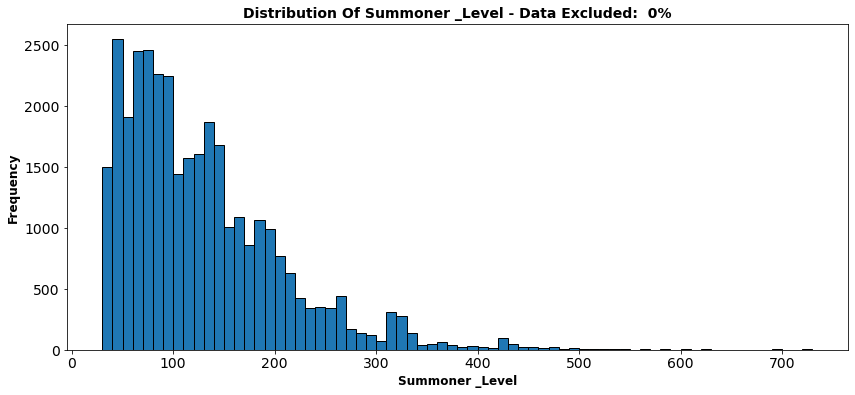

In [33]:
myHistPlot(master_df, 'summoner_level', 10)

We clearly see a right-skewed histogram of summoner levels, it's probably insightful to perform a log transformation here. They are more lower leveled summoners playing ranked league of legends within the time period of year 2020 to 2022. Levels can be a huge factor when dealing with game churn. They are a great determinator for a players activity within the game. 

2) Are higher leveled summoners performing over all better than lower leveled summoners?

In order to answer this what we'll do is create two new dataframes high_level, and low_level and find the avg of their descriptive statistics. I can take the median of the summoner levels as the cutoff to determine what gets binned as low_level or high_level.

In [34]:
median_level = np.median(master_df['summoner_level'])
low_level = master_df[master_df['summoner_level'] < median_level]
high_level = master_df[master_df['summoner_level'] >= median_level]

In [35]:
low_level.describe()

,league_points,wins,losses,assists,kills,deaths,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
count,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000,16838.000000
mean,44.813636,31.313458,37.272657,6.983430,5.176684,6.601556,9737.188740,8893.012709,0.818743,96596.326464,4701.419408,17.228293,69.252465,1735.727640
std,31.389287,47.244315,51.335920,5.480263,4.829143,3.754935,4018.323556,3911.783203,1.183894,66054.523299,5279.813369,13.571932,21.497614,514.093279
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,674.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,191.000000
25%,19.000000,7.000000,10.000000,3.000000,2.000000,4.000000,6971.250000,6235.000000,0.000000,49244.750000,1127.000000,8.000000,50.000000,1398.000000
50%,45.000000,13.000000,18.000000,6.000000,4.000000,6.000000,9394.000000,8625.000000,0.000000,86095.500000,2906.000000,14.000000,69.000000,1744.000000
75%,71.000000,33.000000,41.000000,10.000000,7.000000,9.000000,12112.750000,11250.000000,1.000000,130184.500000,6480.250000,22.000000,87.000000,2067.000000
max,932.000000,734.000000,615.000000,40.000000,39.000000,25.000000,31852.000000,55390.000000,9.000000,902204.000000,65792.000000,180.000000,109.000000,3912.000000


In [36]:
high_level.describe()

,league_points,wins,losses,assists,kills,deaths,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
count,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000,16872.000000
mean,46.804647,51.775545,56.736427,7.642188,5.620910,6.526375,10291.091335,9419.785147,0.952288,104221.381105,4766.137624,20.622570,185.764699,1762.651316
std,30.940447,73.397067,76.235445,5.729374,4.804662,3.736872,4037.569679,3904.587036,1.269331,67965.020434,5555.546173,15.805604,71.733722,508.600962
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,668.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000,191.000000
25%,18.000000,7.000000,10.000000,3.000000,2.000000,4.000000,7520.750000,6750.000000,0.000000,53813.750000,1184.000000,10.000000,135.000000,1435.000000
50%,45.000000,21.000000,25.000000,7.000000,5.000000,6.000000,9979.500000,9125.000000,1.000000,94815.500000,2868.000000,17.000000,166.000000,1768.000000
75%,75.000000,62.000000,67.000000,11.000000,8.000000,9.000000,12701.000000,11725.000000,1.000000,141566.000000,6425.000000,26.000000,211.000000,2091.000000
max,192.000000,632.000000,602.000000,47.000000,39.000000,32.000000,30952.000000,47200.000000,9.000000,610172.000000,82201.000000,142.000000,730.000000,3912.000000


- Higher leveled summoners win more on average.
- Higher leveled summoners gain more league points on average.
- Higher leveled summoners earn more gold per match on average.
- Higher leveled summoners get more turret kills on average.
- Higher leveled summoners deal more total dmg per match on average.

Overall theres a trend to be seen in the descriptive statistics. Higher leveled summoners are more likely to perform better than lower leveled summoners. By my assumptions this has to be due to experience gained about the game over time. They know what champions to play, what lanes to go with those champions, when and how to take objectives, and so on. Theres more factors that I could of analyzed like KDA (kill death assists) ratio but I want to leave that for the feature engineering part. I think KDA will play a big role in the prediction power of churn.

We want to see the first and last matches a player has participated in, this will allow us to see if a user has churned or not. For this we will create new dataframes based off the end of a match "game_end_timestamp", we are not concerned with the start of a match anymore we only needed it to impute the missing end of match timestamps.

In [24]:
#get the first matches a summoner has played
first_game_played = master_df.sort_values(by=['game_end_timestamp']).drop_duplicates(subset='summoner_name', keep='first')
first_game_played

,summoner_name,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,match_id,game_end_timestamp,game_start_timestamp,game_version,assists,kills,deaths,lane,champion_name,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
797,StefenM,100,I,10,13,False,False,False,IRON,NA1_3699752335,2020-12-10 15:43:48,2020-12-10 15:43:46,10.25.348.1797,8,6,8,MIDDLE,Galio,10083,9600,0,77978,92,5,100,1765
26450,Golden melody,30,III,18,29,False,False,False,IRON,NA1_3699759249,2020-12-10 17:24:45,2020-12-10 17:24:43,10.25.348.1797,5,4,6,BOTTOM,Galio,9020,7500,1,78375,2536,18,69,1928
19731,Supreeme Leader,34,I,8,8,False,False,False,IRON,NA1_3699759249,2020-12-10 17:24:45,2020-12-10 17:24:43,10.25.348.1797,7,7,3,TOP,Malphite,11290,10500,2,117585,3363,8,47,1928
14244,EKENS200,0,I,9,12,False,False,False,IRON,NA1_3699800397,2020-12-10 17:44:02,2020-12-10 17:44:02,10.25.348.1797,0,0,0,NONE,Diana,950,500,0,3507,0,0,210,201
30832,GreaseDumpling,12,II,16,18,False,False,False,BRONZE,NA1_3700441426,2020-12-11 02:39:03,2020-12-11 02:39:01,10.25.348.1797,0,0,5,TOP,Mordekaiser,5429,5000,0,68674,4147,20,95,1359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30345,Vesinh,41,I,22,34,False,False,False,BRONZE,NA1_4309050731,2022-05-16 00:43:48,2022-05-16 00:17:41,12.9.439.127,5,3,1,JUNGLE,Vi,10687,9108,4,163869,9629,29,255,1567
27495,Noskill916,72,III,2,13,False,False,False,IRON,NA1_4309281235,2022-05-16 03:52:27,2022-05-16 03:22:20,12.9.439.127,10,13,4,MIDDLE,Swain,12621,11150,3,125383,15164,4,53,1807
32653,NIKISLEPv2,23,IV,45,73,False,False,False,BRONZE,NA1_4309328728,2022-05-16 04:37:51,2022-05-16 04:06:18,12.9.439.127,6,10,10,MIDDLE,Heimerdinger,12786,12100,2,138439,2076,13,76,1892
23605,Professor Orgasm,50,I,32,35,False,False,False,IRON,NA1_4309413183,2022-05-16 05:58:37,2022-05-16 05:20:44,12.9.439.127,8,5,13,JUNGLE,Yone,12019,10800,2,164083,4674,18,133,2272


In [25]:
#get the last matches a summoner has played
last_game_played = master_df.sort_values(by=['game_end_timestamp']).drop_duplicates(subset='summoner_name', keep='last')
last_game_played

,summoner_name,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,match_id,game_end_timestamp,game_start_timestamp,game_version,assists,kills,deaths,lane,champion_name,gold_earned,gold_spent,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
26450,Golden melody,30,III,18,29,False,False,False,IRON,NA1_3699759249,2020-12-10 17:24:45,2020-12-10 17:24:43,10.25.348.1797,5,4,6,BOTTOM,Galio,9020,7500,1,78375,2536,18,69,1928
30323,Art3mis01,35,I,45,42,False,False,False,BRONZE,NA1_3700441426,2020-12-11 02:39:03,2020-12-11 02:39:01,10.25.348.1797,5,2,3,BOTTOM,Morgana,5909,5410,0,17693,1343,40,215,1359
33402,BarditoGrande,0,IV,62,72,False,True,False,SILVER,NA1_3700467302,2020-12-11 03:08:15,2020-12-11 03:08:14,10.25.348.1797,9,0,12,BOTTOM,Rell,5662,5250,0,17124,720,26,112,1537
33523,Mystn,45,III,167,159,False,False,False,GOLD,NA1_3702516958,2020-12-12 19:07:07,2020-12-12 19:07:05,10.25.348.1797,9,11,7,BOTTOM,Lucian,16278,13475,5,198292,4075,21,215,2066
33587,JuliusKoko,36,IV,130,105,False,False,False,GOLD,NA1_3703509336,2020-12-13 10:41:28,2020-12-13 10:41:26,10.25.348.1797,5,6,12,MIDDLE,Ahri,10956,10225,0,91315,1736,7,62,2072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,Zivias,28,I,4,9,False,False,False,IRON,NA1_4309464375,2022-05-16 07:17:50,2022-05-16 06:37:22,12.9.439.127,10,10,7,MIDDLE,Yone,17240,15210,0,276198,3502,16,179,2428
30299,Stiiiz,73,I,57,77,False,False,False,BRONZE,NA1_4309568599,2022-05-16 10:18:50,2022-05-16 09:38:57,12.9.439.127,9,14,11,BOTTOM,Jinx,18411,16450,1,233889,3753,9,94,2392
5303,BootybBandit,45,I,21,24,False,False,False,IRON,NA1_4309575231,2022-05-16 11:41:38,2022-05-16 11:08:39,12.9.439.127,8,3,8,BOTTOM,Leona,8637,7950,0,45465,2903,11,79,1978
14323,N0ctis97,23,I,62,57,False,False,False,IRON,NA1_4309616236,2022-05-16 13:04:25,2022-05-16 12:18:26,12.9.439.127,18,9,9,BOTTOM,MissFortune,15137,13225,0,176718,3877,65,184,2758


In [26]:
#set column to master_df in order to find churn later
master_df['last_match'] = last_game_played['game_end_timestamp']
master_df['last_match'] = master_df.groupby('summoner_name')['last_match'].ffill().bfill()

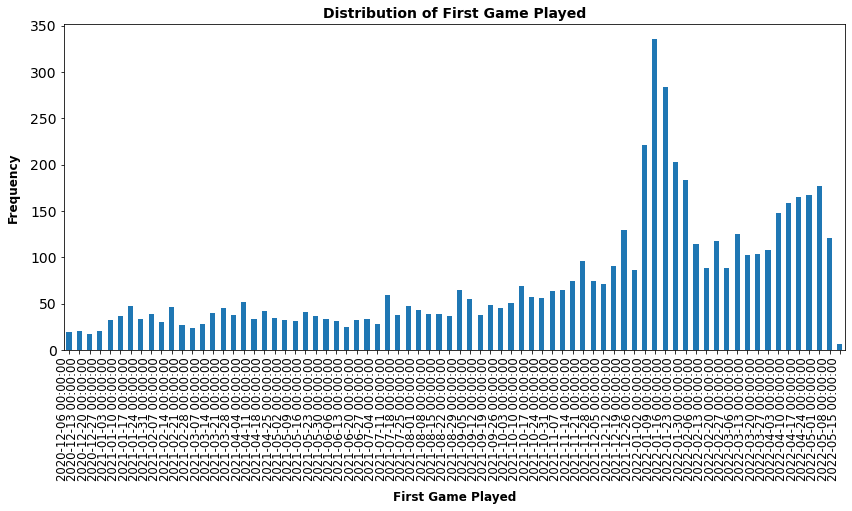

In [40]:
plt.figure(figsize = [14, 6])
first_game_played_plot = first_game_played.set_index('game_end_timestamp')
ax = first_game_played_plot.resample('W', label='left').size().plot.bar()
plt.xticks(rotation=90, horizontalalignment='right', fontsize='small')
plt.title('Distribution of First Game Played', fontsize = 14, weight = 'bold')
plt.xlabel('First Game Played'.title(), fontsize = 12, weight = 'bold', labelpad = 10.0)
plt.ylabel('Frequency'.title(), fontsize = 12, weight = 'bold', labelpad = 10.0);

The distribution is left-skewed for first matches played. We see that more players had their first match about 4 months from the extraction date. As noted earlier we are constrained in how we perform analysis on churn. By my definition the first matches a user played were the earliest dates of the dataset I extracted. So anywhere from 2020-2022 a user could of had their first match played.

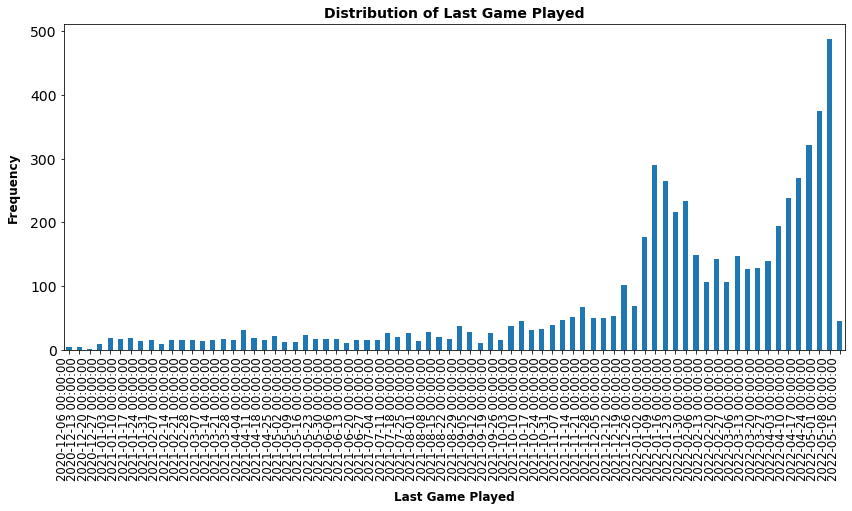

In [41]:
plt.figure(figsize = [14, 6])
last_game_played_plot = last_game_played.set_index('game_end_timestamp')
ax = last_game_played_plot.resample('W', label='left').size().plot.bar()
plt.xticks(rotation=90, horizontalalignment='right', fontsize='small')
plt.title('Distribution of Last Game Played', fontsize = 14, weight = 'bold')
plt.xlabel('Last Game Played'.title(), fontsize = 12, weight = 'bold', labelpad = 10.0)
plt.ylabel('Frequency'.title(), fontsize = 12, weight = 'bold', labelpad = 10.0);

The distribution is left-skewed for last matches played. We see that more players had their last match closer to extraction date (5/17/22). Since I was limited in how much data I could gather (only two years back) we are constrained to doing analysis during the 2020-2022 interval. Keep in mind though that the resampled weekly interval goes up to the date 2022-05-22 which is not included in our data.

In [42]:
#grouping variables based off numeric
numeric_vars = ['league_points', 'wins', 'losses', 
                'assists', 'kills', 'deaths', 'gold_earned', 'gold_spent',
                'turret_kills', 'total_dmg_dealt', 'total_heal', 'vision_score', 'summoner_level', 'time_played']

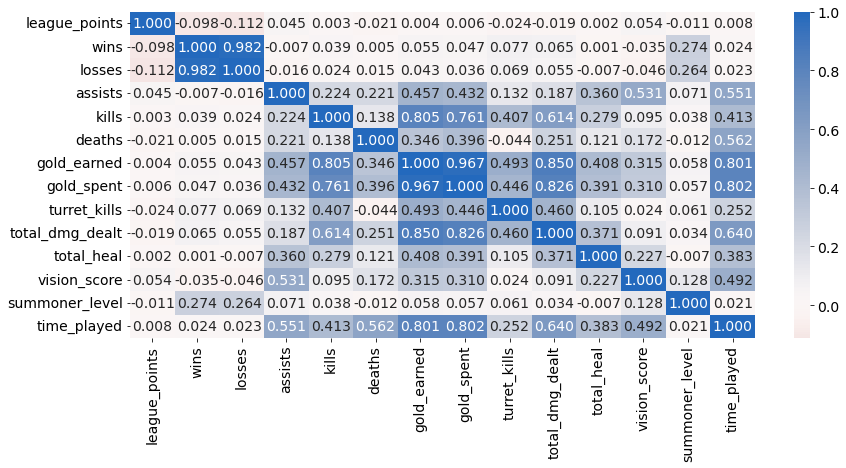

In [43]:
# correlation plot
plt.figure(figsize = [14, 6])
corr_matrix = master_df[numeric_vars].corr(method='pearson')
sns_corr_heatmap = sns.heatmap(corr_matrix, annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

In [45]:
sns_corr_heatmap.figure.savefig("../reports/figures/corr_heatmap.png")

We can conclude any pearson correlation > 0.5 will be of high degree. I will choose to drop some of these highly correlated features to not ruin the models.

gold_earned vs. time_played has correlation of 0.801, I will choose to keep these two because I would like to feature engineer gold earned per min for my models.

gold_spent vs. time_played has correlation of 0.802, and from that we have that gold_earned and gold_spent have correlation of 0.967 which is way above my threshold. I will drop gold_spent in this case.

gold_earned vs. total_dmg_dealt has correlation of 0.850, the only other feature total_dmg_dealt is highly correlated with kills which makes sense, to obtain a "kill" in league of legends one must apply "damage" to the opponents champion's health bar. I will keep total_dmg_dealt, it should have relevant prediction power and feature importance.

No other features have high correlation with more than one feature, thus gold_spent is the only one I shall drop for now.

In [27]:
master_df = master_df.drop('gold_spent', axis=1)

In [47]:
numeric_vars = ['league_points', 'wins', 'losses',
                'assists', 'kills', 'deaths', 'gold_earned',
                'turret_kills', 'total_dmg_dealt', 'total_heal', 'vision_score', 'summoner_level', 'time_played']

It's imperative after a correlation matrix to see a pair plot of each of the features.

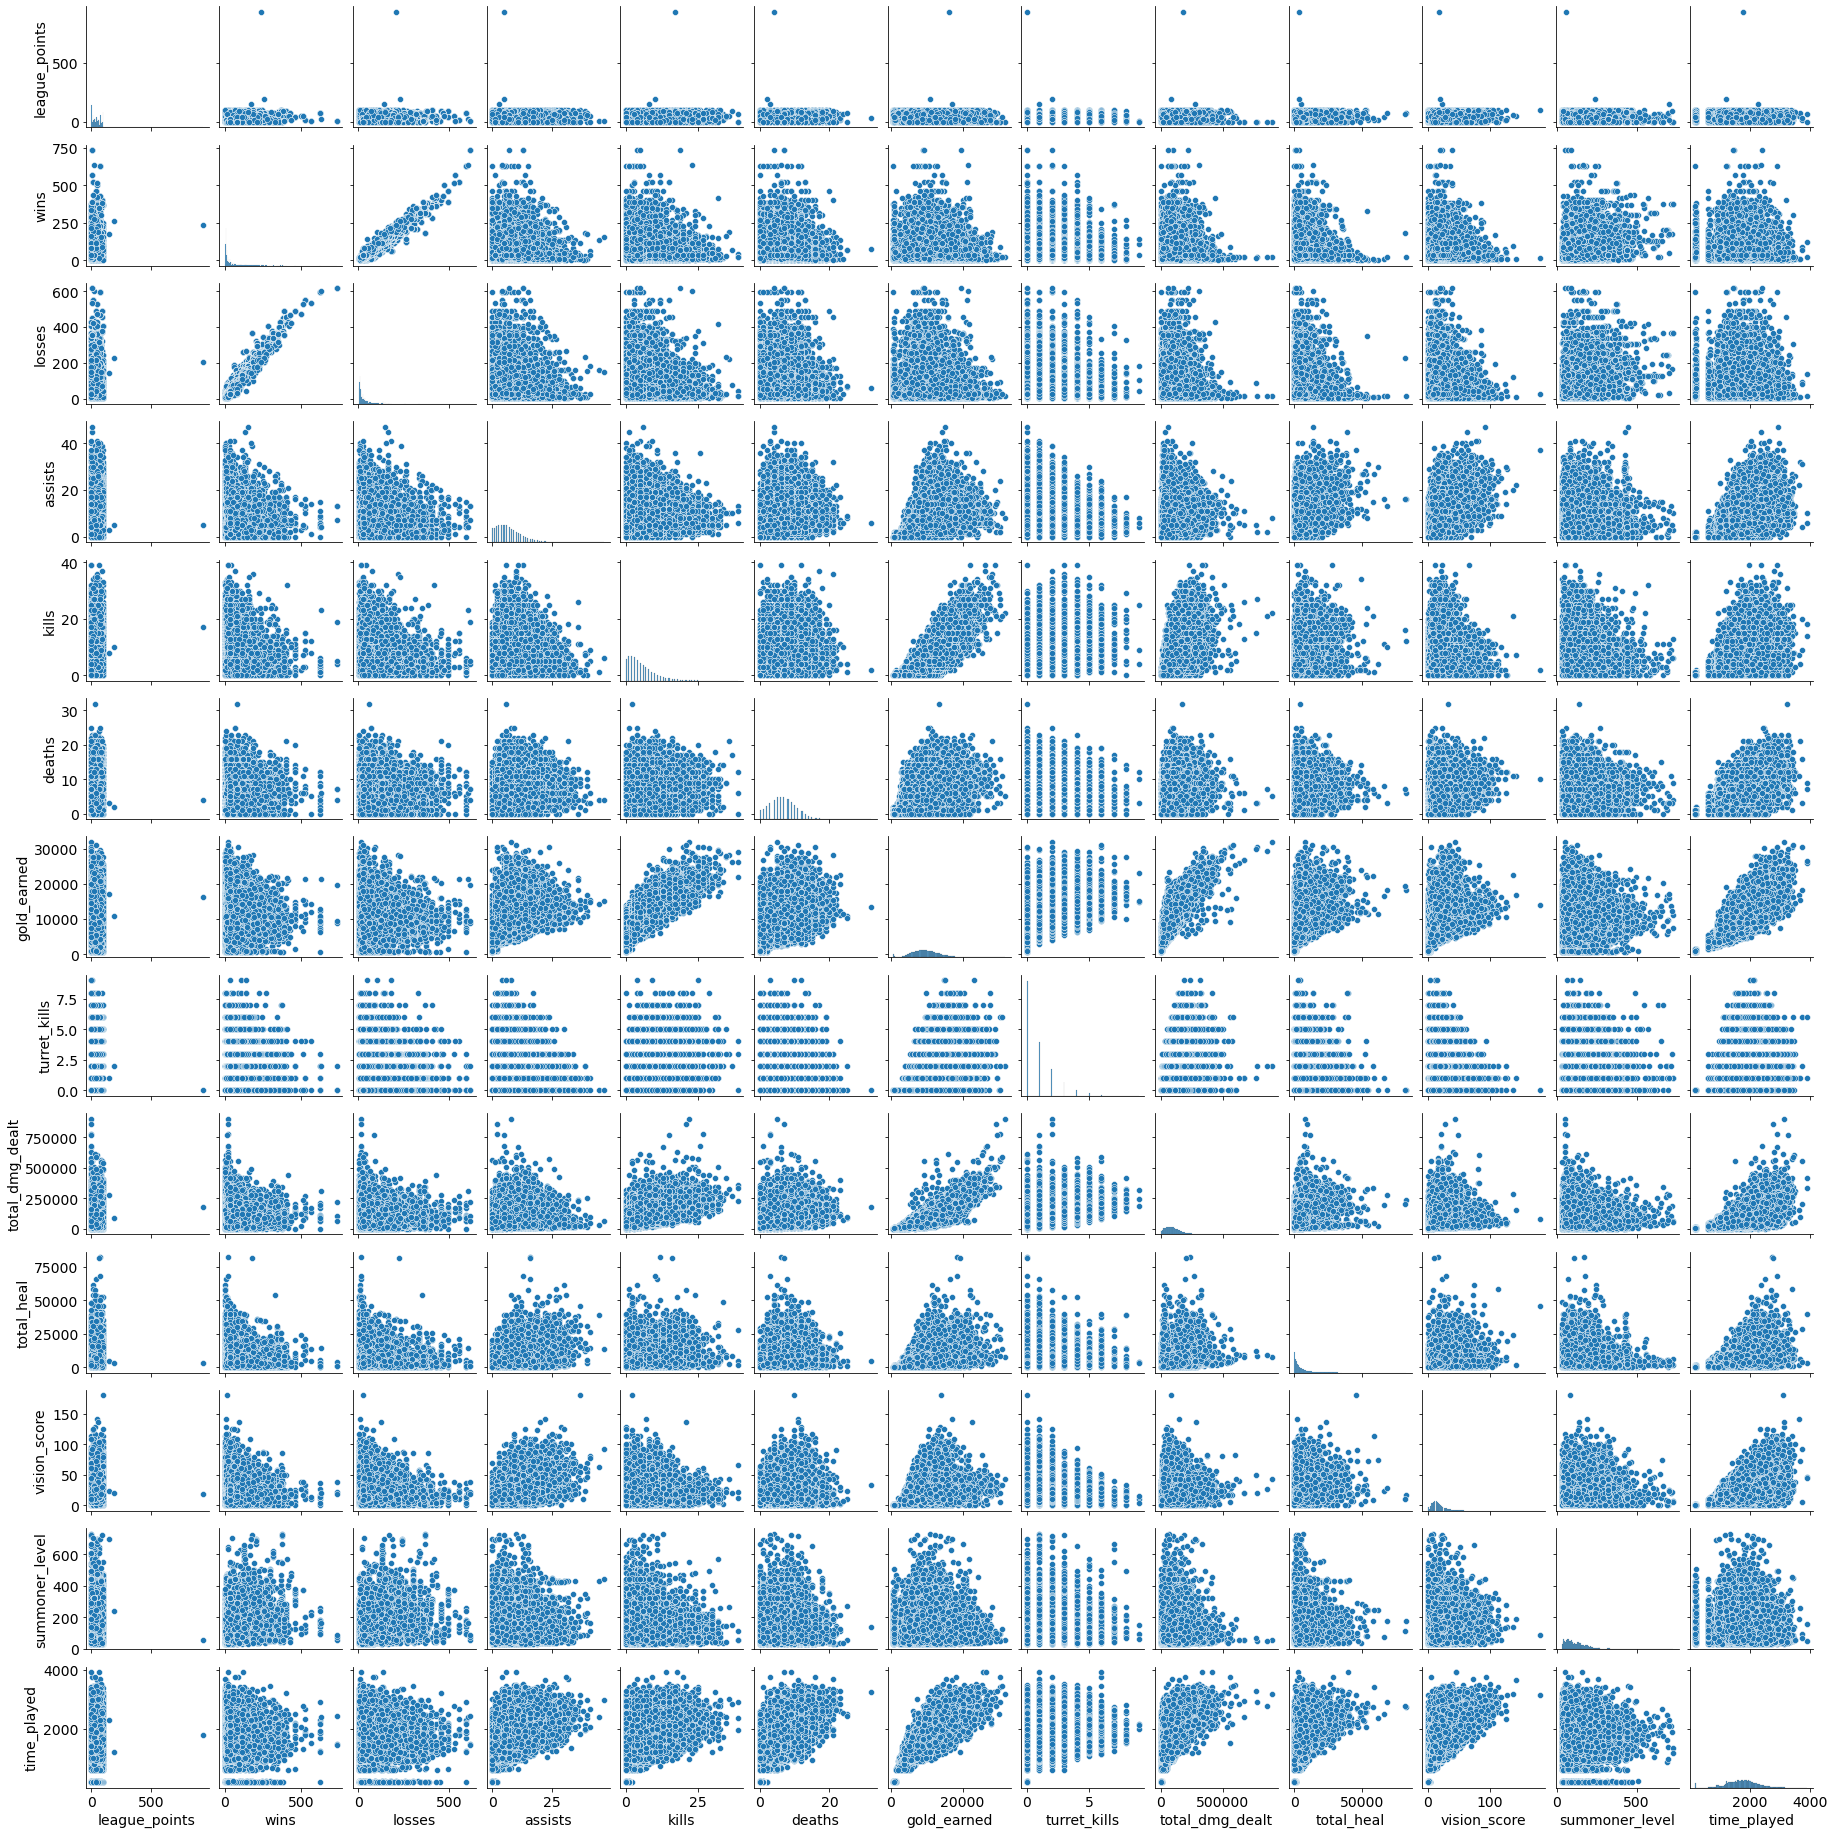

In [48]:
sns_numeric_pairplot = sns.pairplot(master_df[numeric_vars], height=2.0)

Observing outliers in game data is common, you will have higher ranked people performing above average in almost all categories and therefore we won't remove outliers for our model.

In [49]:
#save figure into png file 
sns_numeric_pairplot.savefig("../reports/figures/pairplot.png")
plt.clf() #clean pairplot figure from sns
# Image(filename='pairplot.png')

<Figure size 432x288 with 0 Axes>

bivariate plots of  categorical vs. numeric, summoner level, time, totaldmg, gold

multivariate plots of summoner level, time, totaldmg, gold

feature engineering of kda, gold per min, dmg per min, onehotencoding,


We should observe the categorical features now and see how they relate to the numeric features.

In [28]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33710 entries, 0 to 33709
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   summoner_name         33710 non-null  object        
 1   league_points         33710 non-null  int64         
 2   rank                  33710 non-null  object        
 3   wins                  33710 non-null  int64         
 4   losses                33710 non-null  int64         
 5   veteran               33710 non-null  bool          
 6   fresh_blood           33710 non-null  bool          
 7   hot_streak            33710 non-null  bool          
 8   tier                  33710 non-null  object        
 9   match_id              33710 non-null  object        
 10  game_end_timestamp    33710 non-null  datetime64[ns]
 11  game_start_timestamp  33710 non-null  datetime64[ns]
 12  game_version          33710 non-null  object        
 13  assists         

I would like to compare summoner levels, lanes, and veteran features to see if there are any interesting insights we can build upon. Summoner levels and veteran features by my assumption good predictive power of churn. If a summoner has a higher summoner level they are more likely to be playing the game actively, and the same thing can be said with veteran feature which is of boolean type, a summoner is a veteran is they have been playing league of legends for quite some time.

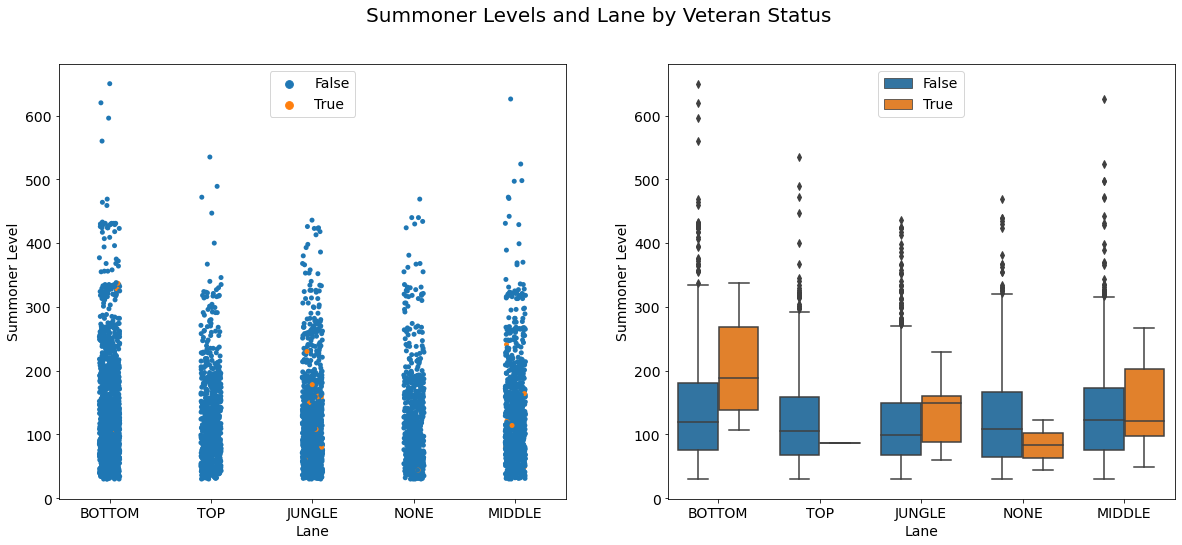

In [51]:
master_df_samp = master_df.sample(5000)
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax[0] = sns.stripplot(x='lane', y='summoner_level', hue='veteran',  data=master_df_samp, size=5, ax=ax[0])
ax[0].set(ylabel="Summoner Level", xlabel="Lane")
ax[0].legend_.set_title("")

ax[1] = sns.boxplot(x='lane', y='summoner_level', hue='veteran', data=master_df_samp, ax=ax[1])
ax[1].set(ylabel="Summoner Level", xlabel="Lane")
ax[1].legend_.set_title("")

plt.suptitle("Summoner Levels and Lane by Veteran Status", fontsize=20);

In [52]:
#save figure into png file 
fig.savefig("../reports/figures/summoner_lane_veteran.png")
plt.clf() #clean pairplot figure from sns
# Image(filename='summoner_lane_veteran.png')

<Figure size 432x288 with 0 Axes>

Veterans have a higher median than non-veterans for all roles. Veterans overall prefer to play the MIDDLE position of the map, the middle position allows you access to all the lanes through the jungle. The mid position is most likely to be designated the captain/leader of the team of 5 players. So this makes sense that older players are more likely to attach themselves to a role thats more in control of the match.

3) Are veteran summoners more likely to perform?

Just like with summoner levels I will create two dataframes containing matches of veterans and non veterans.

In [53]:
veterans = master_df[master_df['veteran'] == True]
non_veterans = master_df[master_df['veteran'] == False]

In [54]:
veterans.describe()

,league_points,wins,losses,assists,kills,deaths,gold_earned,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,37.553763,106.913978,137.198925,7.618280,5.129032,6.559140,10030.494624,0.817204,101811.193548,4620.274194,20.526882,157.123656,1786.731183
std,71.879327,46.234691,56.588684,6.362856,4.707041,4.284384,4013.215429,1.166619,68250.902971,5011.749728,17.649495,92.530204,541.629955
min,0.000000,38.000000,48.000000,0.000000,0.000000,0.000000,702.000000,0.000000,0.000000,0.000000,0.000000,35.000000,196.000000
25%,6.000000,70.500000,97.000000,3.000000,2.000000,3.000000,7361.500000,0.000000,51563.000000,1162.750000,9.000000,92.250000,1479.000000
50%,28.000000,98.000000,129.000000,6.000000,4.000000,6.000000,9986.500000,0.000000,88189.500000,2924.500000,15.000000,129.500000,1788.500000
75%,51.000000,131.750000,153.750000,11.000000,7.000000,9.000000,12468.500000,1.000000,137855.000000,6512.750000,26.750000,216.750000,2209.250000
max,932.000000,287.000000,367.000000,41.000000,23.000000,20.000000,21251.000000,6.000000,366748.000000,26610.000000,86.000000,452.000000,2901.000000


In [55]:
non_veterans.describe()

,league_points,wins,losses,assists,kills,deaths,gold_earned,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played
count,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000,33524.000000
mean,45.855954,41.192191,46.513990,7.311449,5.400519,6.563954,10014.330181,0.885962,100404.939894,4734.441087,18.918268,127.403353,1748.994840
std,30.801769,62.464620,65.427194,5.611552,4.822609,3.742908,4037.611642,1.229540,67119.564831,5421.828649,14.812193,78.628022,511.350187
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,668.000000,0.000000,0.000000,0.000000,0.000000,30.000000,191.000000
25%,18.000000,7.000000,10.000000,3.000000,2.000000,4.000000,7240.000000,0.000000,51468.500000,1157.000000,9.000000,69.000000,1418.000000
50%,45.000000,16.000000,20.000000,6.000000,4.000000,6.000000,9685.500000,0.000000,90527.000000,2889.000000,15.000000,109.000000,1754.000000
75%,73.000000,45.000000,51.000000,10.000000,8.000000,9.000000,12413.250000,1.000000,136013.500000,6454.250000,24.000000,166.000000,2079.000000
max,152.000000,734.000000,615.000000,47.000000,39.000000,32.000000,31852.000000,9.000000,902204.000000,82201.000000,180.000000,730.000000,3912.000000


The amount of veterans in our data is astoundingly low so it might skew the interpretations.

- Veterans earn less league_points on average.
- Veterans win more on average.
- Veterans earn more gold per match on average.
- Veterans destroy less turrets per match on average.
- Veterans deal more total dmg per match on average.
- Veterans place more words and achieve higher vision score on average.

It seems overall on average Veterans are more likely to perform than non-Veterans in ranked League of Legends.

Our master dataset is ready for modeling therefore I will save it to a csv and move on to modeling.

In [56]:
master_df.to_csv('../data/processed/master_lol_churn_prediction.csv', index=False)